# 6: STARmap_CLustering

HDVAE can process STARmap data to extract low-dimension representation. In this tutorial, we use Mouse Visual cortex dataset to introduce the analysis.

The raw data are available at https://www.dropbox.com/sh/f7ebheru1lbz91s/AADm6D54GSEFXB1feRy6OSASa/visual_1020/20180505_BY3_1kgenes?dl=0&subfolder_nav_tracking=1.

The annotation information comes from STAGATE https://drive.google.com/drive/folders/1I1nxheWlc2RXSdiv24dex3YRaEh780my?usp=sharing.

The complete experimental dataset is available here https://zenodo.org/records/15599070

## Preparation

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import torch
warnings.filterwarnings("ignore")

In [2]:
import HDVAE
random_seed = 2023
HDVAE.fix_seed(random_seed)

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
adata = sc.read('../data/STARmap_20180505_BY3_1k.h5ad')

In [4]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)
sc.pp.log1p(adata)
adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata)

from sklearn.decomposition import PCA
adata.obsm['X_pca'] = PCA(n_components=200, random_state=42).fit_transform(adata.X)

## Constructing the spatial network

In [5]:
# construct graph
graph_dict = HDVAE.graph_construction(adata, 12)

In [6]:
adata

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'label_colors', 'hvg', 'log1p'
    obsm: 'spatial', 'X_pca'

## Running HDVAE

In [7]:
hdvae_net = HDVAE.hdvae(adata.obsm['X_pca'], graph_dict, device=device, gcn_hidden2=12, lambda_sim=0.00)
hdvae_net.train_with_dec()
hdvae_feat, _, _, _ = hdvae_net.process()
adata.obsm['HDVAE'] = hdvae_feat

## Clustering

In [8]:
#HDVAE.configure_r_environment()   # If you encounter problems loading R packages, you can manually configure your path in this function.

In [9]:
HDVAE.mclust_R(adata, 7, use_rep='HDVAE', key_added='HDVAE')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label', 'HDVAE'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'label_colors', 'hvg', 'log1p'
    obsm: 'spatial', 'X_pca', 'HDVAE'

### Visualization

<Axes: title={'center': 'HDVAE'}, xlabel='spatial1', ylabel='spatial2'>

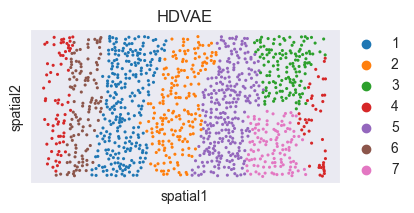

In [10]:
plt.rcParams["figure.figsize"] = (4, 2)
sc.pl.embedding(adata, basis="spatial", color='HDVAE', s=20, show=False, title=f"HDVAE",)#, legend_loc=False)

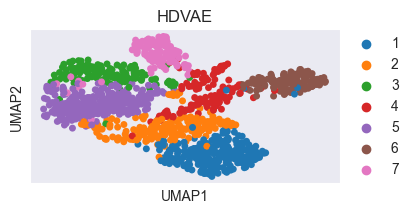

In [11]:
sc.pp.neighbors(adata, use_rep='HDVAE')
sc.tl.umap(adata)
sc.pl.umap(adata, color='HDVAE', title=f"HDVAE",)